# Fake News Detection with BERT
Transformer ML Model Notebook

## Introduction

This notebook builds a fake news detection model that uses machine learning to correctly 
classify news as either real or fake.

The dataset used is the "fake-and-real-news-dataset" from kaggle.

A basline model (TF-IDF and Logistic Regression) will be created first.
The BERT transformer model will then be created after and compared against the baseline.

## Dataset Import and Overview + Data Cleaning

In this section I combine the two CSV files into a single dataset for the rest of the projects use, I also do light cleaning of the data by removing clutter and such

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

fake = pd.read_csv("../data/Fake.csv")
true = pd.read_csv("../data/True.csv")

fake["label"] = 0
true["label"] = 1

df = pd.concat([fake, true]).sample(frac=1).reset_index(drop=True)
df = df.drop_duplicates(subset=["text"], keep="first")
df = df.dropna(subset=["text"])

df["combined_text"] = df["title"].fillna("") + " " + df["text"]
df = df[["combined_text", "label"]]

df.head()

,combined_text,label
0,Oliver Stone: Pokémon Go is ‘Surveillance Capi...,0
1,U.S. flies bombers over Korea as Trump discuss...,1
2,Clinton Wins Big In New York Democratic Prima...,0
3,Russia may seize U.S. property if its own comp...,1
4,Ethics office concerned about White House not ...,1


## Training and Testing Split

The dataset will be train/test split into a 80/20 split respectively, and this split will be used for everything

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["combined_text"], df["label"], test_size=0.2, random_state=42
)

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

sample = tokenizer(
    X_train.iloc[0],
    padding="max_length",
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

sample

c:\Users\colli\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': tensor([[  101,  8398,  3049,  3208,  1998,  5766,  2041,  2098,  2004,  2372,
          1997,  1037,  3595,  2521,  1011,  2157,  4654,  7913, 23738,  2177,
          1996,  2670,  5635,  2375,  2415,  2207,  1037,  3189,  2006,  9317,
          1010, 26256,  2119,  1997,  1996, 14751, 13134,  2000,  1996,  8398,
          3049,  2004,  2372,  1997,  1037, 28607,  2521,  1011,  2157,  4654,
          7913, 23738,  2177,  2081,  2039,  1997,  1996,  2087,  3928, 11992,
          1998,  2317, 10514, 28139, 22911,  5130,  1999,  1996,  2142,  2163,
          1012,  1999,  2054,  2001,  2649,  2004,  1037,  6073,  6279,  1010,
          8398,  5086,  4603, 14592,  3334,  5163, 20147, 14783,  1998,  7987,
         20175,  8237,  2102,  2502, 16279,  4459,  7221,  8540,  2004,  2010,
          3049,  1055,  5766,  1006,  3649,  1996,  3109,  2008,  2003,  1010,
          2144,  4883,  8008,  2123,  1056,  2031,  5766,  1055,  1012,  1007,
          2429,  2000,  1996, 22889, 1

## Basline Model

This call makes the baseline using TF-IDF vectorization and Logistic Regression for classification

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_tfidf, y_train)

pred_base = logreg.predict(X_test_tfidf)

baseline_acc = accuracy_score(y_test, pred_base)
baseline_f1 = f1_score(y_test, pred_base)

print("Baseline Accuracy:", baseline_acc)
print("Baseline F1:", baseline_f1)

Baseline Accuracy: 0.9864165588615783
Baseline F1: 0.9876803942273847


## BERT Tokenizer and Data Prep

This section loads the BERT tokenizer and prepares said tokenization functions for the BERT Model

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 256

## Change to huggingFace Dataset Format

The training and testing data isconverted into huggingface objects so that they can be tokenized as a bach, which is more efficient for processing

In [6]:
from datasets import Dataset

train_ds = Dataset.from_pandas(pd.DataFrame({
    "combined_text": X_train,
    "label": y_train
}))

test_ds = Dataset.from_pandas(pd.DataFrame({
    "combined_text": X_test,
    "label": y_test
}))

def tokenize(batch):
    return tokenizer(
        batch["combined_text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_tokenized = train_ds.map(tokenize, batched=True)
test_tokenized = test_ds.map(tokenize, batched=True)

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 7730/7730 [00:45<00:00, 168.45 examples/s]


## BERT Setup

This section loads a pre-trained BERT model for binary classification, it also defines the conputation fuctions for accuracy and F1 scores

In [25]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

## Training the BERT Model

This section sets the training arguments and actually intializes the huggingface trainer 

In [27]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="../models",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

Step,Training Loss
500,0.013000
1000,0.002300
1500,0.008700
2000,0.006900
2500,0.005000
3000,0.004500
3500,0.002800
4000,0.009300
4500,0.005600
5000,0.004400


c:\Users\colli\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\colli\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=11595, training_loss=0.0030367668983460262, metrics={'train_runtime': 26302.4424, 'train_samples_per_second': 3.526, 'train_steps_per_second': 0.441, 'total_flos': 1.2247819627008e+16, 'train_loss': 0.0030367668983460262, 'epoch': 3.0})

## Results and Confusion Matrix

This section shows the results of the trained BERT Model and shows the confusion matrix for it

In [20]:
results = trainer.evaluate()
results

c:\Users\colli\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.002614145865663886,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9997412677878396,
 'eval_f1': 0.999763816721776,
 'eval_runtime': 379.9055,
 'eval_samples_per_second': 20.347,
 'eval_steps_per_second': 2.545}

c:\Users\colli\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


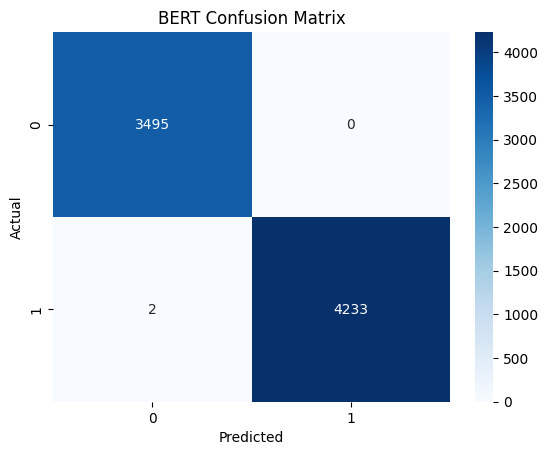

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_results = trainer.predict(test_tokenized)
preds = np.argmax(pred_results.predictions, axis=1)

cm = confusion_matrix(y_test, preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Baseline VS BERT Model

This section just compares the baseline model to the trained BERT model

In [22]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["Baseline (TF-IDF + Logistic Regression)", "BERT"],
    "Accuracy": [baseline_acc, accuracy_score(y_test, preds)],
    "F1 Score": [baseline_f1, f1_score(y_test, preds)]
})

comparison

,Model,Accuracy,F1 Score
0,Baseline (TF-IDF + Logistic Regression),0.986417,0.987680
1,BERT,0.999741,0.999764
